5. (45 pts total) In this question, we will investigate the statistical properties of online social networks by analyzing the Facebook100 (“FB100”) data set (download from the class Canvas). Each of the 100 plaintext ASCII files in the FB100 folder contains an edge list for a 2005 snapshot of a Facebook social network among university students and faculty within some
university. Interpret this edge list as a simple graph. 

(a) (10 pts) For each of the FB100 networks, calculate the mean degree $〈k〉$ and then make a nice histogram figure showing the empirical distribution of mean degree. Comment on the range of $〈k〉$ you find, and whether it agrees or disagrees with your intuition, given what you know about these schools (feel free to look a few up to learn something about
them).

*Hint*: If you use a standard histogram plotting function, don’t use the default number of bins (often just 10). Instead, set the bin width equal to $c,$ for some small-ish integer $c$

In [1]:
# imports
import networkx as nx
import glob
import pandas as pd
import numpy as np
from plotnine import *
from collections import deque

In [2]:
def calculate_paradox_ratio(G):
    # Calculate node degrees
    degrees = dict(G.degree())

    # Calculate mean squared degree
    mean_squared_degree = np.mean([d**2 for d in degrees.values()])

    # Calculate mean degree
    mean_degree = np.mean(list(degrees.values()))

    # Mean neighbor degree calculation
    mean_neighbor_degree = mean_squared_degree / mean_degree

    # Paradox ratio calculation
    paradox_ratios = {}
    for node in G.nodes():
        # Get neighbors' degrees
        neighbor_degrees = [degrees[neighbor] for neighbor in G.neighbors(node)]

        # Mean of neighbor degrees
        if neighbor_degrees:
            mean_neighbor_degree_for_node = np.mean(neighbor_degrees)
            paradox_ratios[node] = mean_neighbor_degree_for_node / degrees[node]

    # Overall network paradox ratio
    overall_paradox_ratio = mean_neighbor_degree / mean_degree

    return {
        "mean_degree": mean_degree,
        "mean_neighbor_degree": mean_neighbor_degree,
        "overall_paradox_ratio": overall_paradox_ratio,
        "node_paradox_ratios": paradox_ratios,
    }

In [3]:
# Read all files in the FB100 directory
network_files = glob.glob("facebook100txt/*.txt")

# Remove all attribute files
network_files = [file for file in network_files if "attr" not in file]

# Process each network file
results = []
for file in network_files:
    try:
        # Load the graph
        G = nx.read_edgelist(file, nodetype=int, comments="id")

        # Extract network name from filename
        network_name = file.split("/")[-1].split(".")[0]

        # Calculate paradox metrics
        paradox_metrics = calculate_paradox_ratio(G)

        # Store results
        result = {
            "network": network_name,
            "mean_degree": paradox_metrics["mean_degree"],
            "paradox_ratio": paradox_metrics["overall_paradox_ratio"],
        }
        results.append(result)

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

Error processing facebook100txt/facebook100_readme_aaron.txt: Failed to convert nodes Readme,for to type <class 'int'>.
Error processing facebook100txt/facebook100_readme_021011.txt: Failed to convert nodes Readme,for to type <class 'int'>.


In [5]:
# Convert mean degrees to a DataFrame
df = pd.DataFrame({"Mean_Degree": results_df["mean_degree"]})

bin_width = 2
bins = range(0, int(max(results_df['mean_degree'])) + bin_width, bin_width)


# Create the histogram using plotnine
plot = (
    ggplot(df, aes(x="Mean_Degree"))
    + geom_histogram(binwidth=bin_width, fill="skyblue", color="black")
    + labs(
        title="Histogram of Mean Degree for Facebook 100 Networks",
        x=r"Mean Degree $(\langle k \rangle)$",
        y="Frequency",
    )
    + theme_minimal()
    # + theme(panel_background=element_rect(fill="white"))
)

# Display the plot
plot.save("figures/mean_degree_histogram.png")

/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/mean_degree_histogram.png


(c) (15 pts) Using all of the FB100 networks, make a figure showing a scatterplot of the
size of the paradox, defined as the ratio $\frac{〈kv〉}{〈ku〉}$ , as a function of the mean degree $〈ku〉$. Include a horizontal line representing the line of “no paradox,” and label the nodes corresponding to Reed, Colgate, Mississippi, Virginia, and UC Berkeley. (Remember: figures without axes labels will receive no credit.)

Now comment on (i) the degree to which we do or do not observe a friendship paradox
across these networks as a group, and on what makes the five labeled points notable, and
(ii) whether there is any dependency between the size of the paradox and the network’s
mean degree.

(5 pts extra credit) Explain why we should, in fact, expect to see a friendship paradox
in these networks, in terms of the conditions under which we should expect to see no
paradox

Equation derived in Question 5, part b

$ \langle k_v \rangle = \frac{\langle k^2 \rangle}{\langle k \rangle}$

In [6]:
target_schools = ["Reed", "Colgate", "Mississippi", "Virginia", "UC Berkeley"]
for school in results_df["network"]:
    for target in target_schools:
        if target.lower() in school.lower():
            print(school)

# Lets rename these schools to make them more readable
results_df["network"] = results_df["network"].replace(
    {
        "Reed98": "Reed",
        "Colgate88": "Colgate",
        "Mississippi66": "Mississippi",
        "Virginia63": "Virginia",
        "Berkeley13": "UC Berkeley",
    }
)

# Lets add another column to the dataframe to indicate if the school is a target school
# Lets make this column the name of the school so we can color the points in the plot
results_df["school"] = results_df["network"].apply(
    lambda x: x if x in target_schools else "Other"
)

results_df['target_school'] = results_df['network'].apply(lambda x: x in target_schools)

Virginia63
Colgate88
Mississippi66
Reed98


In [7]:
plot = (
    ggplot(
        results_df,
        aes(x="mean_degree", y="paradox_ratio", color="school", size="target_school"),
    )
    + geom_point()
    + geom_hline(yintercept=1, linetype="dashed", color="red")
    + labs(
        x=r"Mean Degree $\langle k_u \rangle$",
        y=r"Paradox Ratio $\frac{\langle k_{v} \rangle}{\langle k_{u} \rangle}$",
        title="Friendship Paradox across Facebook 100 Networks",
    )
    + theme_minimal()
    + theme(legend_position="none")  # Remove legend
    + geom_text(
        data=results_df[results_df["target_school"] == True],
        mapping=aes(label="school"),
        nudge_x=0,
        nudge_y=0.1,
        size = 8
    )
    + geom_text(
        # include text over line of no paradox
        data=pd.DataFrame({
            "x": (max(results_df["mean_degree"] - min(results_df["mean_degree"])) / 2) + min(results_df["mean_degree"]),
            "y": [1], 
            "label": ["Line of No Paradox"]}),
        mapping=aes(x="x", y="y", label="label"),
        nudge_x=0.5,
        nudge_y=0.05,
        size = 8,
        color = "red"
    )
)

plot.save("figures/paradox_ratio_plot.png")

/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/paradox_ratio_plot.png
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/scales/scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


(e) (20 pts extra credit) Most social networks also have very small diameters relative to their total size. This property is sometimes called the “small-world phenomenon” and is the origin of the popular phrase “six degrees of separation”.

- For each FB100 network, compute (i) the diameter $\ell_{max}$ of the largest component of the network and (ii) the mean geodesic distance $\langle \ell \rangle$ between pairs of vertices in
the largest component of the network. Make two ﬁgures, one showing $\ell_{max}$ versus network size $n$ and one showing $\langle \ell \rangle$ versus the size of the largest component $n$. Comment on the degree to which these ﬁgures support the six-degrees of separation idea.

*Hint*: it’s okay to use a library function to compute $\ell_{max} and $\langle \ell \rangle$, but it’ll be a slow calculation.

- Brieﬂy discuss whether and why you think the diameter of Facebook has increased, stayed the same, or decreased relative to these values, since 2005. (Recall that Facebook now claims to have roughly $10^9$ accounts.)

In [19]:
def read_edgelist(file):
    """Read an edge list file and return an adjacency list representation."""
    adjacency_list = {}

    with open(file) as f:
        for line in f:
            v1, v2 = map(int, line.split())
            # Add both directions since Facebook connections are undirected
            adjacency_list.setdefault(v1, set()).add(v2)
            adjacency_list.setdefault(v2, set()).add(v1)

    return adjacency_list


def bfs_with_distances(graph, start):
    """
    Performs BFS and returns both visited nodes and their distances from start.
    Returns:
        - set of visited nodes
        - dict of distances to each node
    """
    visited = set()
    distances = {start: 0}
    queue = deque([start])

    while queue:
        node = queue.popleft()
        if node not in visited:
            visited.add(node)

            for neighbor in graph[node]:
                if neighbor not in visited:
                    queue.append(neighbor)
                    if neighbor not in distances:
                        distances[neighbor] = distances[node] + 1

    return visited, distances


def find_largest_component(graph):
    """Find the largest connected component in the graph."""
    visited_all = set()
    largest_component = set()

    for node in graph:
        if node not in visited_all:
            component, _ = bfs_with_distances(graph, node)
            visited_all.update(component)

            if len(component) > len(largest_component):
                largest_component = component

    return largest_component


def compute_network_metrics(graph):
    """
    Compute diameter and mean geodesic distance for the largest component.
    Returns:
        - size of largest component
        - diameter
        - mean geodesic distance
    """
    largest_component = find_largest_component(graph)

    # Pick arbitrary start node for first BFS
    start_node = next(iter(largest_component))
    _, distances = bfs_with_distances(graph, start_node)

    # Find the furthest node
    max_dist_node = max(distances.items(), key=lambda x: x[1])[0]

    # Run BFS from furthest node to get diameter
    _, final_distances = bfs_with_distances(graph, max_dist_node)
    diameter = max(final_distances.values())

    # Calculate mean geodesic distance
    total_distance = sum(final_distances.values())
    num_pairs = len(final_distances)
    mean_geodesic = total_distance / num_pairs

    return len(largest_component), diameter, mean_geodesic


def analyze_networks(network_files):
    """Analyze all networks and create visualization."""
    results = []

    for file in network_files:
        try:
            print(f"Processing {file}...")
            graph = read_edgelist(file)
            component_size, diameter, mean_geodesic = compute_network_metrics(graph)
            results.append(
                {
                    "file": file,
                    "component_size": component_size,
                    "diameter": diameter,
                    "mean_geodesic": mean_geodesic,
                }
            )
            print(f"Completed {file}")
        except Exception as e:
            print(f"Error processing {file}: {e}")

    return results

Processing facebook100txt/Haverford76.txt...
Completed facebook100txt/Haverford76.txt
Processing facebook100txt/Harvard1.txt...
Completed facebook100txt/Harvard1.txt
Processing facebook100txt/Princeton12.txt...
Completed facebook100txt/Princeton12.txt
Processing facebook100txt/UC64.txt...
Completed facebook100txt/UC64.txt
Processing facebook100txt/Middlebury45.txt...
Completed facebook100txt/Middlebury45.txt
Processing facebook100txt/William77.txt...
Completed facebook100txt/William77.txt
Processing facebook100txt/Vermont70.txt...
Completed facebook100txt/Vermont70.txt
Processing facebook100txt/Northwestern25.txt...
Completed facebook100txt/Northwestern25.txt
Processing facebook100txt/Northeastern19.txt...
Completed facebook100txt/Northeastern19.txt
Processing facebook100txt/Dartmouth6.txt...
Completed facebook100txt/Dartmouth6.txt
Processing facebook100txt/Yale4.txt...
Completed facebook100txt/Yale4.txt
Processing facebook100txt/Bucknell39.txt...
Completed facebook100txt/Bucknell39.tx

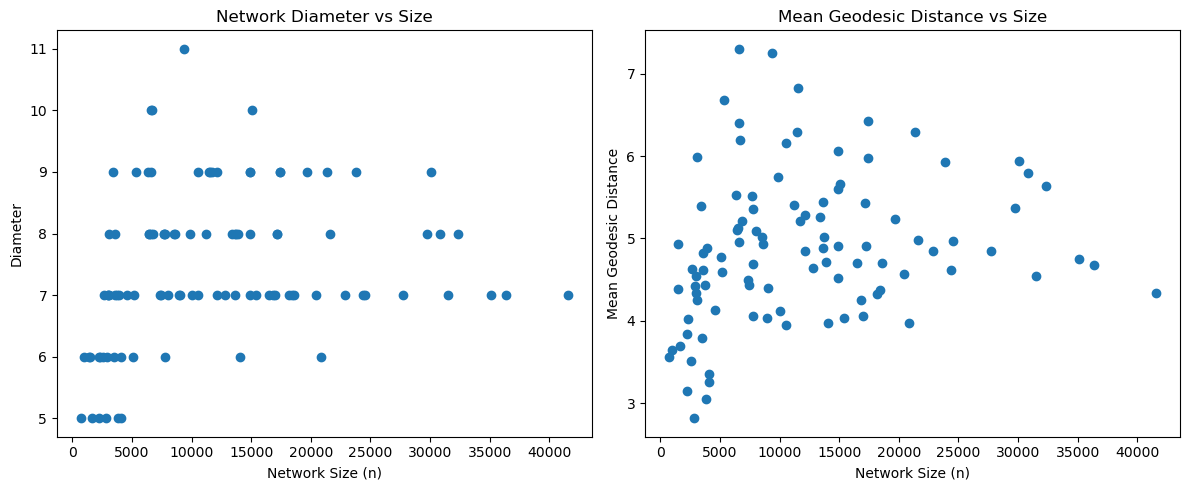

In [22]:
network_results = analyze_networks(network_files)

In [65]:
# lets make ggplots for network diameter vs size and mean geodesic distance vs size
# Convert to DataFrame
results_df = pd.DataFrame(network_results)

# Plot diameter vs network size
plot = (
    ggplot(
        results_df,
        aes(x="factor(diameter)", y="component_size", color="factor(diameter)"),
    )
    + geom_boxplot()
    + geom_point()
    + labs(x="Network Size (n)", y="Diameter", title="Network Diameter vs Size")
    + theme_minimal()
    + theme(legend_position="none")
)

plot.save("figures/diameter_vs_size.png")

# Plot mean geodesic distance vs network size
plot = (
    ggplot(
        results_df,
        aes(x="mean_geodesic", y="component_size", color="factor(mean_geodesic)"),
    )
    + geom_point()
    + labs(
        x="Network Size (n)",
        y="Mean Geodesic Distance",
        title="Mean Geodesic Distance vs Size",
    )
    + theme_minimal()
    + theme(legend_position="none")
)
plot.save("figures/mean_geodesic_distance_vs_size.png")

/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/diameter_vs_size.png
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/mean_geodesic_distance_vs_size.png
